In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.integrate import solve_ivp
from numba import njit

In [ ]:
def temperature(t, offset = 0): # Temperature function in kelvin
    return (4*np.cos(2*np.pi*(t + offset)/365.25 + 9.2) + 28.0) + 273.15
    
def temperature_const(t,offset = 0): # Constant temperature
    return 301

def humidity(t, offset = 0): # Humidity function in percent
    return 60 #+ 30*np.cos(6*np.pi*(t + offset)/365.25 + 9.2) + 10*np.cos(8*np.pi*(t + offset)/365.25 + 9.2)

def transition_rate(evt, T, R0, Ha, Hh, T12, R): # Transition rate function from one state to another
    return R0[evt]*(T/298)*np.exp(Ha[evt]*(1/298 - 1/T)/R)/(1 + np.exp(Hh[evt]*(1/T12[evt] - 1/T)/R))

def adult_rate(T, R0, Ha, Hh, T12, R): # Transition rate function from larvae to pupae to adult
    egg_transi = transition_rate(0, T, R0, Ha, Hh, T12, R)
    larvae_transi = transition_rate(1, T, R0, Ha, Hh, T12, R)
    pupae_transi = transition_rate(2, T, R0, Ha, Hh, T12, R)
    death_L = 0.01 + 0.9725*np.exp(-0.1*(T - 278)/2.7035)
    death_P = 0.01 + 0.9725*np.exp(-0.1*(T - 278)/2.7035)

    return egg_transi*larvae_transi*pupae_transi/((pupae_transi + death_P) * (larvae_transi + death_L))

# definition of the different mortality rates : 
def egg_death(T) : 
    if T < 288 : 
        return 0
    else :
        return 0.011 # A calculer

In [ ]:
def mating(M, Ms):
    return M / (1 + M + Ms)

def event(i, state, M_event):
    return state + M_event[i]

def release1(M, n):
    return n*M + 2000

def competition1(K0, Kh, precip):
    return 1/(K0 + Kh *  precip)

def competition2(K0, Kh, preciptemp):
    return rsp/deltaA * (K0 + Kh * (T/298)*np.exp(0.05*(1 - H/100)))

In [ ]:
#open the meteorological data
import pandas as pd
meteo_df = pd.read_csv('../Data/meteo_tetiaroa_resampled.csv')
print("Columns in meteo_df:", meteo_df.columns)

precip_data = meteo_df['precip'].values
precip1_data = meteo_df['precip1'].values
precip2_data = meteo_df['precip2'].values
precip4_data = meteo_df['precip4'].values
hum_data = meteo_df['UM'].values
temperature_data = meteo_df['TM'].values
dates_data = meteo_df['date'].values
dates_dt = pd.to_datetime(dates_data)
time_data = meteo_df['time'].values

Columns in meteo_df: Index(['date', 'time', 'TM', 'precip', 'precip1', 'precip2', 'precip4', 'UM'], dtype='object')


In [ ]:
mean_rain = np.mean(precip_data)
max_rain = np.max(precip_data)
print("Mean Rain:", mean_rain)
print("Max Rain:", max_rain)

Mean Rain: nan
Max Rain: nan


In [ ]:
Precmax = np.max(precip_data)
deltaprecip = 0.00001 * (25 + temperature_data ** 2) * (100 - hum_data)
# Cumsum of the deltaprecip normalized by Precmax, where value minimum is 0 and maximum is Precmax
H_data = np.zeros_like(precip_data)
H_data[0] = mean_rain*6
for i in range(1, len(precip_data)):
    H_data[i] = min(max_rain, max(0, H_data[i-1] + precip_data[i] - deltaprecip[i]))

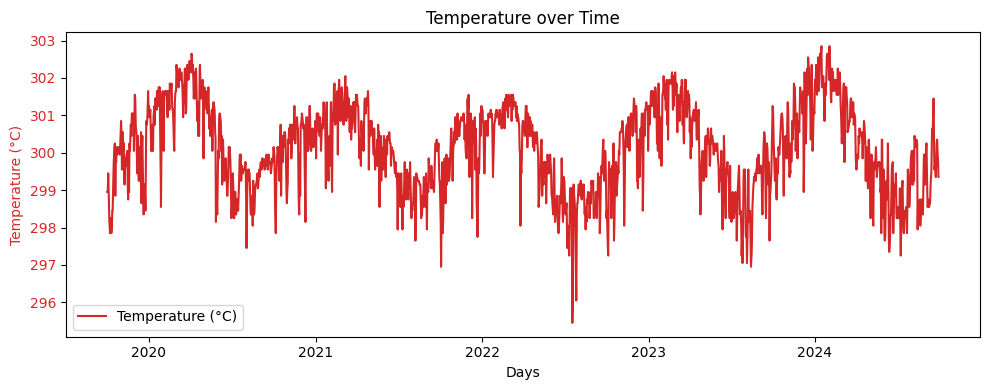

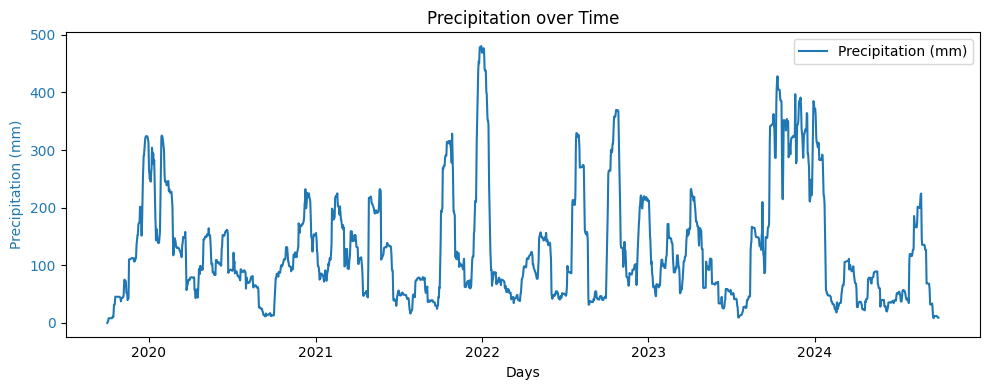

In [ ]:
# Plot temperature and precipitation in two separate graphs
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(dates_dt, temperature_data + 273.15, label='Temperature (°C)', color='tab:red')
ax1.set_xlabel('Days')
ax1.set_ylabel('Temperature (°C)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_title('Temperature over Time')
plt.legend()
plt.tight_layout()
plt.show()

fig, ax2 = plt.subplots(figsize=(10, 4))
ax2.plot(dates_dt, precip4_data, label='Precipitation (mm)', color='tab:blue')
ax2.set_xlabel('Days')
ax2.set_ylabel('Precipitation (mm)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title('Precipitation over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Population model

In [ ]:
def det_model(y, t, birth, n_egg, deltaA, deltaE, comp, mu, R0, Ha, Hh, T12, R, temperature_data, precip_data):
    E, F, Ff, Fs, M, Ms = y
    i = int(t*100001/1552)-1
    #T = temperature(t)
    #T = temperature_const(t)
    T = temperature_data[i] + 273.15
    #precip = precip_data[i]
    precip = 0

    Hum = humidity(t)

    if T < 276:
        death_egg = 0.001
        transi = 0
        deltaA = 2 * deltaA

    else:
        transi = adult_rate(T, R0, Ha, Hh, T12, R)
        death_egg = deltaE + competition(1/comp, 1/(comp * 30), precip) * E + (transition_rate(0, T, R0, Ha, Hh, T12, R) - transi)
        deltaA = 0.091
    if M + Ms == 0:
        probaM = 0
        probaMs = 0
    else:
        probaM = 2 * M / (2 * M + Ms)
        probaMs = Ms / (2 * M + Ms)
    matf = mating(0.01*M, 0.001*Ms)* probaM
    mats = mating(0.001*Ms, 0.01*M)* probaMs
    
    # Differential equations
    dE_dt = n_egg * birth * Ff - death_egg * E
    dF_dt = mu * transi * E - (matf + mats + deltaA) * F
    dFf_dt = matf * F - deltaA * Ff
    dFs_dt = mats * F - deltaA * Fs
    dM_dt = (1 - mu) * transi * E - deltaA * 2 * M
    dMs_dt = - deltaA * 1.2 * Ms
    return [dE_dt, dF_dt, dFf_dt, dFs_dt, dM_dt, dMs_dt]

def sim(pop_init, days, birth, deltaA, deltaE, comp, mu, R0, Ha, Hh, T12, R, n_egg=64, temperature_data=temperature_data, precip_data=precip_data):
    # Solve the differential equations
    pop0 = pop_init
    E, F, Ff, Fs, M, Ms = [], [], [], [], [], []

    solution = odeint(
        det_model, pop0, days,
        args=(birth, n_egg, deltaA, deltaE, comp, mu, R0, Ha, Hh, T12, R, temperature_data, precip_data)
    )
    E0, F0, Ff0, Fs0, M0, Ms0 = solution.T
    E.extend(E0)
    F.extend(F0)
    Ff.extend(Ff0)
    Fs.extend(Fs0)
    M.extend(M0)
    Ms.extend(Ms0)
    
    pop0 = [E[-1], F[-1], Ff[-1], Fs[-1], M[-1], Ms[-1]]
    
    return E, F, Ff, Fs, M, Ms

def sim_interv(n_intervals, pop_init, days, birth, deltaA, deltaE, comp, mu, R0, Ha, Hh, T12, R, n_egg=64, temperature_data=temperature_data, precip_data=precip_data):
    # Solve the differential equations
    pop0 = pop_init
    E, F, Ff, Fs, M, Ms = [], [], [], [], [], []
    # Divide the time in n_intervals
    taille_intervals = len(days)//n_intervals
    intervals = [days[i * taille_intervals : (i + 1) * taille_intervals] for i in range(n_intervals - 1)] + [days[(n_intervals - 1) * taille_intervals :]]

    for interval in intervals:
        solution = odeint(
            det_model, pop0, interval,
            args=(birth, n_egg, deltaA, deltaE, comp, mu, R0, Ha, Hh, T12, R, temperature_data, precip_data)
        )
        E0, F0, Ff0, Fs0, M0, Ms0 = solution.T
        E.extend(E0)
        F.extend(F0)
        Ff.extend(Ff0)
        Fs.extend(Fs0)
        M.extend(M0)
        Ms.extend(Ms0)
        
        if interval[-1] > 750 and F[-1] + Ff[-1] + Fs[-1] > 200 and 3 ==4:
            Ms[-1] = Ms[-1] + release1(M[-1],50)
            #print("release", Ms[-1])

        pop0 = [E[-1], F[-1], Ff[-1], Fs[-1], M[-1], Ms[-1]]
    
    return E, F, Ff, Fs, M, Ms

In [ ]:
#@njit
def det_model_fast8(t, y, birth, n_egg, deltaA, death_egg, tel, tlp, transi, death_L, death_P, c, mu, t_data, precip_data, H, type = 1):
    E, L, P, F, Ff, Fs, M, Ms = y

    #precip = 0.0  

    if type == 1:
        precip = np.interp(t, t_data, precip_data)
        comp = competition1(1/c, 1/(c * 50), precip)
    
    if type == 2:
        water = np.interp(t, t_data, H)
        comp = 1 /((1 /(0.2 * c) * water / (max_rain) + 1/(5 * c)))

    if M > 0:
        probaM = 2 * M / (2 * M + Ms)
        probaMs = Ms / (2 * M + Ms)

    else:
        probaM = 0.0
        probaMs = 0.0

    matf = mating(0.01*M, 0.001*Ms) * probaM
    mats = mating(0.001*Ms, 0.01*M) * probaMs

    dE_dt = n_egg * birth * Ff - death_egg * E - tel * E
    dL_dt = tel * E - (tlp + death_L + comp * L) * L
    dP_dt = tlp * L - (transi + death_P) * P
    dF_dt = mu * transi * E - (matf + mats + deltaA) * F
    dFf_dt = matf * F - deltaA * Ff
    dFs_dt = mats * F - deltaA * Fs
    dM_dt = (1 - mu) * transi * E - deltaA * 3.021739130434783 * M
    dMs_dt = - deltaA * 3.021739130434783 * 1.2 * Ms

    return np.array([dE_dt, dL_dt, dP_dt, dF_dt, dFf_dt, dFs_dt, dM_dt, dMs_dt])


def sim_fast8(pop_init, days, birth, deltaA, deltaE, transi_el, transi_lp, transi_pa, death_L, death_P, c, mu,n_egg=64, precip_data=precip_data, H = H_data, type = 1):
    
    sol = solve_ivp(
        lambda t, y: det_model_fast8(
            t, y, birth, n_egg, deltaA, deltaE, transi_el, transi_lp, transi_pa, death_L, death_P, c, mu,
            time_data, precip_data, H, type
        ),
        [days[0], days[-1]],
        pop_init,
        t_eval=days,
        method='LSODA',  # or 'RK45'
        vectorized=False
    )

    return sol.y  # [E, F, Ff, Fs, M, Ms]

In [ ]:

init_egg = 10000  # Starting egg population
init_l = 1000 # Starting larval population
init_p = 1000 # Starting pupal population
init_f0 = 100 # Starting female population
init_ff = 1200 # Starting fertilised female pop
init_fs = 0 # Starting strerile female pop
init_male = 400 # Starting adult population
init_sterile = 0 # Starting sterile male population
comp_larvae = 0.0001 # Competition coefficient for larvae
n_rel = 0
n_egg = 64

In [ ]:
# Parameters
birth = 10/64  # Birth rate per adult
mu = 0.51    # rate at which egg becomes a female
egg_death = 0.046    # Death rate per egg
larva_death = 0.05   # Death rate per larva
pupa_death = 0.05   # Death rate per pupa
female_death = 0.046  # Death rate per adult
male_death = 0.139    # Death rate per adult
sterile_death = male_death*1.2   # Death rate per sterile
c = 0.01 # Competition coefficient for larvae
transi_el = 0.79
transi_lp = 0.125
transi_pa = 0.125
t=0.0

days = np.linspace(0, 1552, 155100)  # Time steps
pop = [init_egg, init_l, init_p, init_f0, init_ff, init_fs, init_male, init_sterile]

In [ ]:
E, L, P, F, Ff, Fs, M, Ms = sim_fast8(pop, time_data, birth, female_death,egg_death, transi_el, transi_lp, transi_pa, larva_death, pupa_death, c, mu, n_egg=n_egg, precip_data = precip2_data, H = H_data, type = 1)
print(max(E), max(F), max(Ff), max(Fs), max(M), max(Ms))
print(min(E), min(F), min(Ff), min(Fs), min(M), min(Ms))

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1155226903623D+04   r2 =                  NaN
1.612085825063636e+176 7.397949861606219e+174 1.9009313323580475e+175 0.0 2.047809468067526e+175 0.0
10000.0 100.0 1199.9999999999998 0.0 400.0 0.0


/tmp/ipykernel_8086/2806319163.py:27: RuntimeWarning: overflow encountered in scalar multiply
  dL_dt = tel * E - (tlp + death_L + comp * L) * L
/tmp/ipykernel_8086/2806319163.py:31: RuntimeWarning: invalid value encountered in scalar multiply
  dFs_dt = mats * F - deltaA * Fs
/tmp/ipykernel_8086/2806319163.py:16: RuntimeWarning: invalid value encountered in scalar divide
  probaM = 2 * M / (2 * M + Ms)
/tmp/ipykernel_8086/972948719.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return M / (1 + M + Ms)
/home/leo/Documents/These/Codes/SIT_models/.venv/lib/python3.12/site-packages/scipy/integrate/_ivp/lsoda.py:222: RuntimeWarning: divide by zero encountered in divide
  x = ((t - self.t) / self.h) ** self.p[:, None]
/home/leo/Documents/These/Codes/SIT_models/.venv/lib/python3.12/site-packages/scipy/integrate/_ivp/lsoda.py:161: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  solver._y, solver.t = integrator.run(


ValueError: x and y must have same first dimension, but have shapes (187500,) and (17902,)

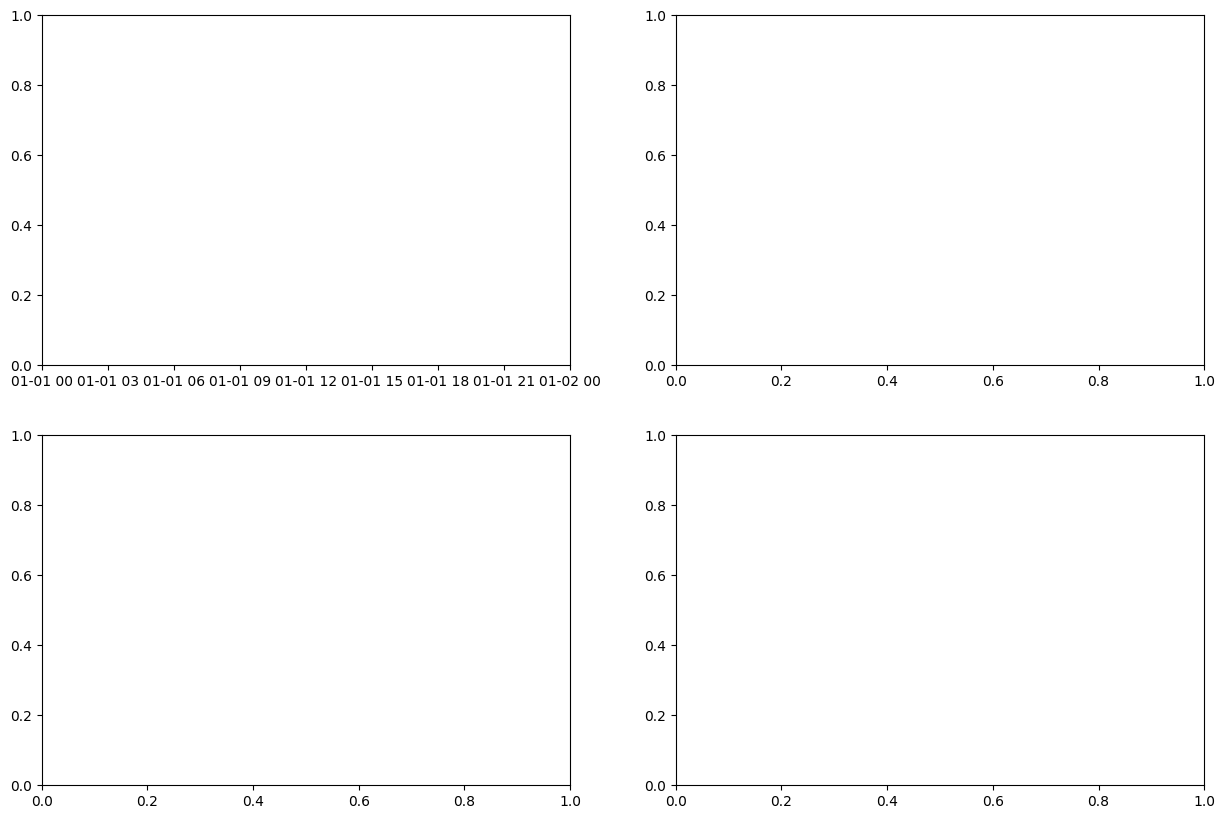

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(dates_dt, F, where="post", label='F0', color = 'blue')
axs[0, 0].step(dates_dt, Ff, where="post", label='Ff', color = 'red')
axs[0, 0].step(dates_dt, Fs, where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(dates_dt, Ms, where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(dates_dt, E, where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(dates_dt,[F[i] + Ff[i] + Fs[i] for i in range(len(F))], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(dates_dt, M, where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()
